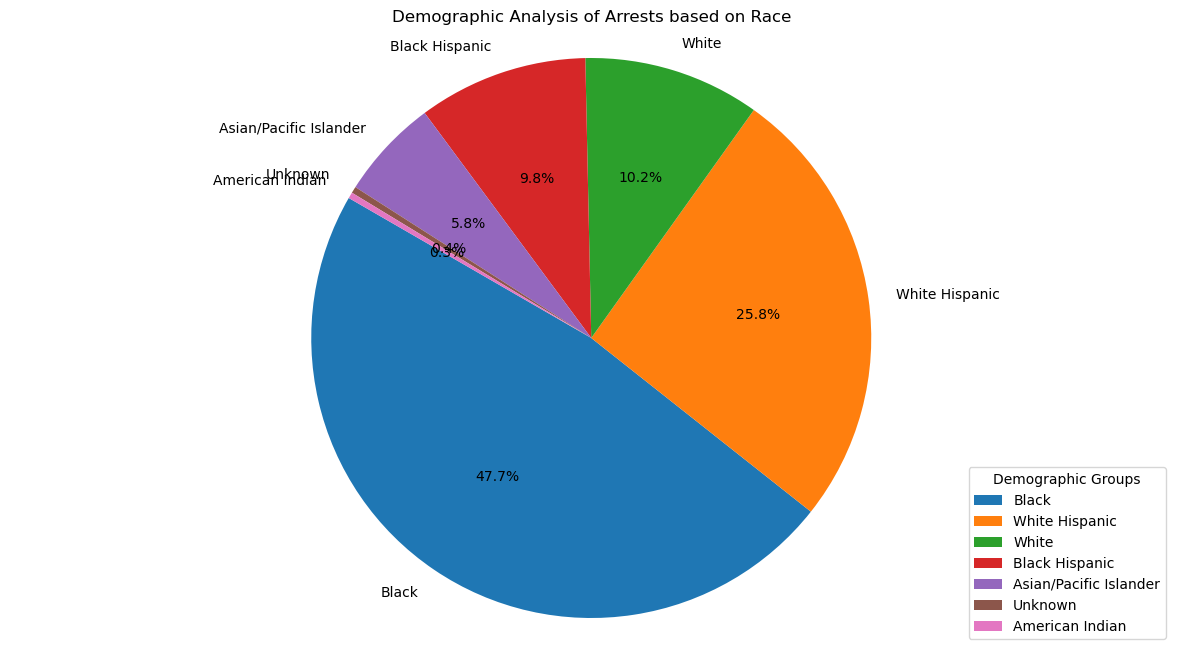

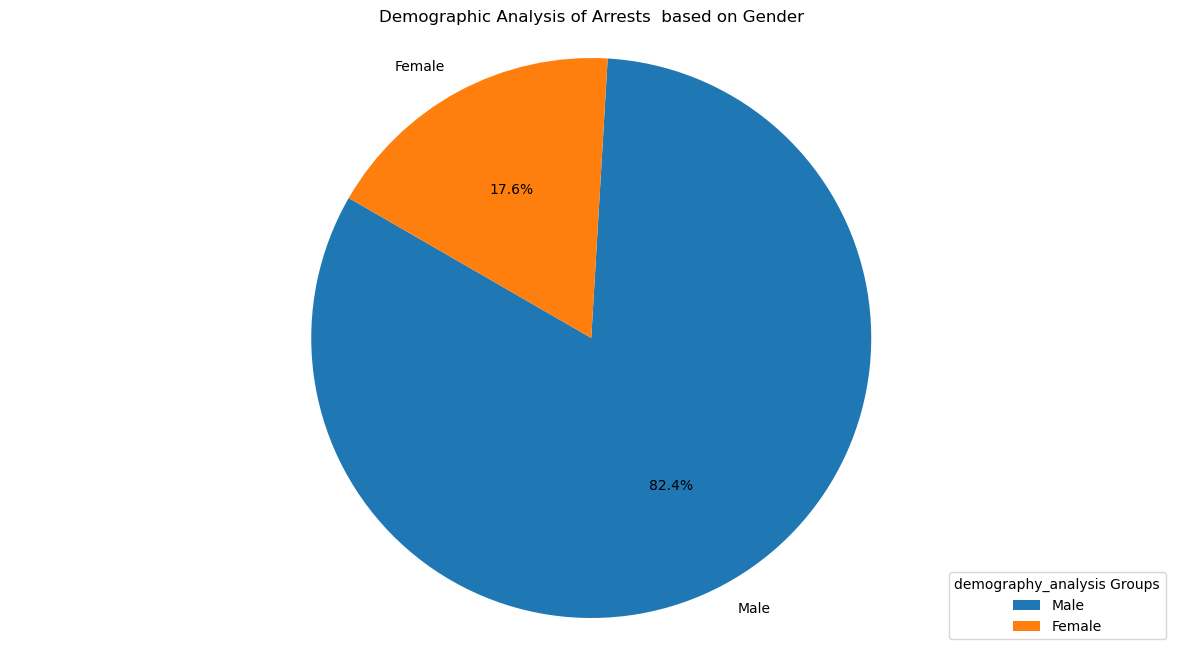

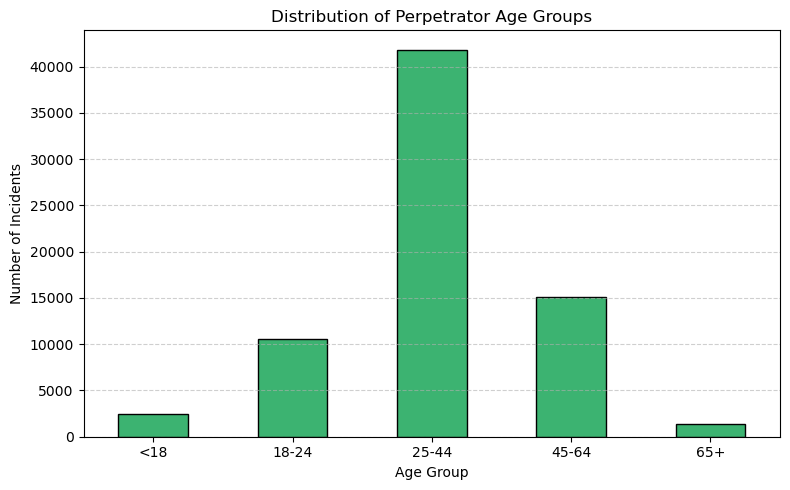

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
def eda(df):
    print("dataframe shape: ", df.shape)
    print("dataframe columns: ", df.columns)
    print("dataframe dtypes: ", df.dtypes)

def boro_vise_analyis(df):
    boro_crime_count = df.groupby('ARREST_BORO')['ARREST_KEY'].count()
    boro_avg_income = {
        'B': 49,  # Bronx
        'K': 77,  # Brooklyn
        'M': 101, # Manhattan
        'Q': 85,  # Queens
        'S': 95   # Staten Island
    }
    boro_population = {
        'B': 1.4,  # Bronx
        'K': 2.736, # Brooklyn
        'M': 1.6,   # Manhattan
        'Q': 2.3,   # Queens
        'S': 0.5    # Staten Island
    }
    boro_no_of_pricents = { 
        'B': 12,  # Bronx
        'K': 23,  # Brooklyn
        'M': 22,   # Manhattan
        'Q': 16,  # Queens
        'S': 4  # Staten Island
    }
    boro_df = pd.DataFrame({
        'Borough': boro_crime_count.index,
        'Crime_Count': boro_crime_count.values,
        'Population': [boro_population[boro] for boro in boro_crime_count.index],
        'Median_Income': [boro_avg_income[boro] for boro in boro_crime_count.index],
        'No_of_Pricents': [boro_no_of_pricents[boro] for boro in boro_crime_count.index]
    })
    incomes = [boro_avg_income[boro] for boro in boro_crime_count.index]
    #income vs crime count
    fig, ax1 = plt.subplots(figsize=(10, 6))
    bars = ax1.bar(boro_crime_count.index, boro_crime_count.values, color='blue', label='Crime Count')
    ax1.set_ylabel('Crime Count', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax2 = ax1.twinx()
    ax2.plot(boro_crime_count.index, boro_df['Median_Income'], color='red', linewidth=2,marker='o')
    ax2.set_ylabel('Median Income (scaled to $1000)', color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    plt.title('Crime Count vs Median Income by Borough')
    plt.show()
    #population vs crime count
    fig, ax1 = plt.subplots(figsize=(10, 6))
    bars = ax1.bar(boro_crime_count.index, boro_crime_count.values, color='blue', label='Crime Count')
    ax1.set_ylabel('Crime Count', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax2 = ax1.twinx()
    ax2.plot(boro_crime_count.index,boro_df['Population'] , color='red', linewidth=2,marker='o')
    ax2.set_ylabel('population per milloion', color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    plt.title('Crime Count vs Population by Borough')
    plt.show()
    #no of pricents vs crime count
    fig, ax1 = plt.subplots(figsize=(10, 6))
    bars = ax1.bar(boro_crime_count.index, boro_crime_count.values, color='blue', label='Crime Count')
    ax1.set_ylabel('Crime Count', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax2 = ax1.twinx()
    ax2.plot(boro_crime_count.index,boro_df['No_of_Pricents'] , color='red', linewidth=2,marker='o')
    ax2.set_ylabel('No of Pricents', color='black')
    ax2.tick_params(axis='y', labelcolor='black')
    plt.title('Crime Count vs Population by Borough')
    plt.show()
    #correlation matrix
    fig, ax1 = plt.subplots(figsize=(10, 6))
    corrq=boro_df[['Crime_Count','Median_Income','Population','No_of_Pricents']].corr()
    sns.heatmap(corrq, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation between Crime Count, Median Income, Population and No of Pricents')
    plt.show()
def demography_analysis(df):
    # Demographic analysis baced on race
    demographic_counts = df['PERP_RACE'].value_counts()
    demographic_counts = demographic_counts.rename(index={
    'BLACK': 'Black',
    'WHITE': 'White',
    'WHITE HISPANIC': 'White Hispanic',
    'BLACK HISPANIC': 'Black Hispanic',
    'ASIAN / PACIFIC ISLANDER': 'Asian/Pacific Islander',
    'UNKNOWN': 'Unknown',
    'AMERICAN INDIAN/ALASKAN NATIVE': 'American Indian'
    })

    plt.figure(figsize=(15, 8))
    plt.pie( demographic_counts.values,labels=demographic_counts.index, autopct='%1.1f%%', startangle=150)
    plt.legend(title='Demographic Groups',loc='lower right')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title('Demographic Analysis of Arrests based on Race')
    plt.show()
    # Demographic analysis based on gender
    demographic_counts = df['PERP_SEX'].value_counts()
    demographic_counts = demographic_counts.rename(index={
        'M': 'Male',
        'F': 'Female',
        'U': 'Unknown'})
    plt.figure(figsize=(15, 8))
    plt.pie(demographic_counts.values,labels=demographic_counts.index, autopct='%1.1f%%', startangle=150)
    plt.legend(title='demography_analysis Groups',loc='lower right')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title('Demographic Analysis of Arrests  based on Gender')
    # Demographic analysis based on age
    # Desired order of age groups
    age_order = ['<18', '18-24', '25-44', '45-64', '65+']
    age_counts = df['AGE_GROUP'].value_counts().reindex(age_order)
    plt.figure(figsize=(8, 5))
    age_counts.plot(kind='bar', color='mediumseagreen', edgecolor='black')

    plt.title("Distribution of Perpetrator Age Groups")
    plt.xlabel("Age Group")
    plt.ylabel("Number of Incidents")
    plt.xticks(rotation=0)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
if __name__ == "__main__":
    df = pd.read_csv('NYPD_Arrest_Data__Year_to_Date_.csv')
    #boro_vise_analyis(df)
    demography_analysis(df)